<a href="https://colab.research.google.com/github/wajidminhas/AI-Agents/blob/main/reducer_chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%%capture --no-stderr
%pip install --quiet -U langchain-google-genai langchain_core langgraph

create gemini api key to start chat model

In [3]:
from google.colab import userdata
google_api_key = userdata.get('GEMINI_API_KEY')

here chat model is being created with metadata, using gemini chat model flash 1.5 chat google generative ai

In [4]:
from os import name
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint

messages = [AIMessage(content=f"how can i help you?", name="Model")]
messages.append(HumanMessage(content=f"i want to enjoy snow falling in northern pakistan", name="Wajid"))
messages.append(AIMessage(content=f"That sounds like a beautiful idea!", name="Model"))

for m in messages:
  # PrettyPrinter(f"{m.type}: {m.content} (from {m.name})")
  m.pretty_print()

llm: ChatGoogleGenerativeAI = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=google_api_key)
result = llm.invoke(messages)
type(result)

================================== Ai Message ==================================
Name: Model

how can i help you?
================================ Human Message =================================
Name: Wajid

i want to enjoy snow falling in northern pakistan
================================== Ai Message ==================================
Name: Model

That sounds like a beautiful idea!


langchain_core.messages.ai.AIMessage

In [5]:
result

AIMessage(content="Enjoying snowfall in Northern Pakistan requires planning, as conditions can vary greatly depending on the specific location and time of year.  Here's a breakdown of how you can best experience it:\n\n**1. Choosing a Location & Time:**\n\n* **Specific Areas:** Northern Pakistan offers many stunning locations.  Popular choices include:\n    * **Swat Valley:** Known for its picturesque landscapes and relatively accessible resorts.\n    * **Hunza Valley:** Famous for its breathtaking scenery, including the Karakoram Highway.\n    * **Gilgit-Baltistan:** Offers a wider range of experiences, from milder snowfall in lower valleys to heavy snow in higher altitudes.  Consider areas like Naran Kaghan, or even higher up towards the glaciers.\n    * **Neelum Valley (Azad Kashmir):**  Another beautiful valley with stunning snow-covered landscapes.\n\n* **Time of Year:** Snowfall typically occurs from late autumn (November) to early spring (March/April), with the heaviest snowfall

In [6]:
def personalize(name: str, place: str)-> str:
  """
  here a person will give his name to find information of his location,

  arg
  name: str
  place: str

  return
  str
  """
  return f"{name} is from {place}"

llm_with_toolcall : ChatGoogleGenerativeAI = llm.bind_tools([personalize])


In [7]:
tool_call = llm_with_toolcall.invoke([HumanMessage(content=f"my name is wajid and my place is jhelum, what do you know about jhelum", name="wajid")])
tool_call

AIMessage(content='', additional_kwargs={'function_call': {'name': 'personalize', 'arguments': '{"place": "jhelum", "name": "wajid"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-6635c22b-5a5e-474f-95e6-571d1415f6f3-0', tool_calls=[{'name': 'personalize', 'args': {'place': 'jhelum', 'name': 'wajid'}, 'id': 'a1b8589e-475f-4455-831f-f123b4e6d200', 'type': 'tool_call'}], usage_metadata={'input_tokens': 90, 'output_tokens': 9, 'total_tokens': 99, 'input_token_details': {'cache_read': 0}})

TO CHECK ADDITIONAL KEYWORD ARGUMENTS MEAN METADATA

In [8]:
tool_call.additional_kwargs

{'function_call': {'name': 'personalize',
  'arguments': '{"place": "jhelum", "name": "wajid"}'}}

Message using as state

In [9]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage

class State(TypedDict):
  messages: list[AnyMessage]

In [10]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):

    pass

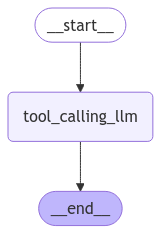

In [11]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph.state import CompiledStateGraph

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_toolcall.invoke(state["messages"])]}

# Build graph
builder: StateGraph = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph: CompiledStateGraph  = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I help you?


In [14]:
messages = graph.invoke({"messages": HumanMessage(content="my name is wajid and my place is jhelum, what do you know about my place")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

my name is wajid and my place is jhelum, what do you know about my place
================================== Ai Message ==================================
Tool Calls:
  personalize (d62bd480-c8b3-4f5c-ad08-c296c30fad55)
 Call ID: d62bd480-c8b3-4f5c-ad08-c296c30fad55
  Args:
    place: jhelum
    name: wajid
